# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
import numpy as np
from datetime import datetime
import os
import time
import copy
from IPython.display import FileLink, display 
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import LogNorm
%matplotlib notebook

from lmfit import  Model  # lmfit for fitting

import skbeam.core.correlation as corr
import skbeam.core.roi as roi
import skbeam.core.utils as utils
import skbeam.core.mask as sb_mask
import xray_vision.mpl_plotting.roi as roi_plot

from chxanalys.chx_libs import getpass, db
from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames, show_img,
                                             load_data, load_mask, apply_mask, create_time_slice,
                                             get_each_frame_intensity, create_hot_pixel_mask)
from chxanalys.chx_compress_analysis import (compress_eigerdata, read_compressed_eigerdata, 
                                             Multifile, get_t_iqc,
                                            get_each_ring_mean_intensityc)
from chxanalys.XPCS_SAXS import get_circular_average, get_ring_mask
from chxanalys.Two_Time_Correlation_Function import (Get_Pixel_Array, auto_two_Array,show_C12,
                                                     get_one_time_from_two_time)
from chxanalys.chx_correlationc import (cal_g2c,Get_Pixel_Arrayc,
                                        auto_two_Arrayc,get_pixelist_interp_iq)

/opt/conda_envs/analysis/lib/python3.4/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


##  Retrieve the image data and the metadata for the anlaysis

In [2]:
CYCLE = '2016_2'
uid = 'b5feeb' #Measurement: Silica 10k fr x .002 exp, mbs 0.1x0.6, bds 15x15, prekin .1x.08 
               #Note: we used this data for Sameera's paper

In [3]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  1846--b5feeb96-cdb0-455f-b078-1b6052326c27--/XF11ID/data/2016/07/02/c983dd73-350b-424d-ac5e_8192


In [4]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/07/02/c983dd73-350b-424d-ac5e_8192_master.h5


## image data : used 10000 frames for the XPCS analysis

In [5]:
imgs

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

In [6]:
md

{'beam_center_x': 1232.0,
 'beam_center_y': 903.0,
 'count_time': 0.00199,
 'detector_distance': 4.8400002,
 'frame_time': 0.0020000001,
 'framerate': 499.99997625127548,
 'incident_wavelength': 1.2846771,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [7]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000      # detector to sample distance (mm)

exposuretime= md['count_time']
acquisition_period = md['frame_time']

timeperframe =exposuretime

center = [1227, 1261]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))
center=[center[1], center[0]]
print (center), (timeperframe)

[1261, 1227]


(None, 0.00199)

In [8]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, center=center)
setup_pargs

{'Ldet': 4840.0,
 'center': [1261, 1227],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2846771,
 'timeperframe': 0.00199,
 'uid': 'b5feeb'}

## Get the mask and find the bad frames

<IPython.core.display.Javascript object>


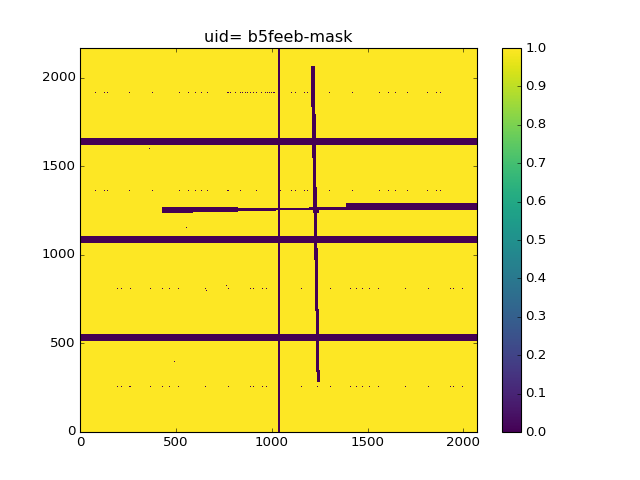

In [9]:
mask_path = '/XF11ID/analysis/2016_2/masks/'
mask_name = 'fcdba400-4b7e_mask.npy'
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time serie

In [64]:
filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1]
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                                        force_compress=False, bad_pixel_threshold=100000,nobytes=4)

Averaging images:   1%|▏         | 137/10000 [00:00<00:07, 1368.92it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_b5feeb96-cdb0-455f-b078-1b6052326c27.cmp.


Get each frame intensity: 100%|██████████| 10000/10000 [00:02<00:00, 4540.55it/s]

Bad frame list are: [  33  188  672 1954 2202 2260 2359 2431 3103 3168 3358 3699 4096 4327 4734
 4926 4945 5071 5567 5810 6207 6776 6918 7023 7281 7360 7375 7394 7449 7480
 7693 7816 8757 8944 9378 9535 9706]


In [12]:
cm = copy.copy(plt.get_cmap("viridis"))
cm.set_bad('k')
axis_font = {'fontname':'Arial', 'size':'20'}
axis_font2 = {'fontname':'Arial', 'size':'14'}

<IPython.core.display.Javascript object>


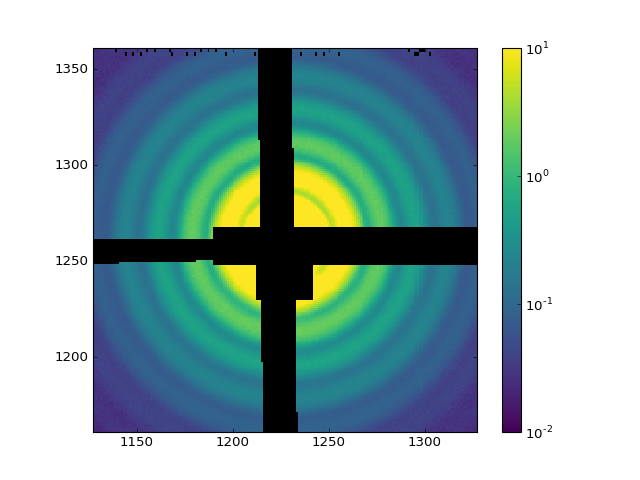

In [13]:
fig, ax = plt.subplots()
im =ax.imshow(avg_img, origin='lower', cmap=cm,
              interpolation="nearest" , norm=LogNorm(vmin=0.01,  vmax=10))        
rwidth = 100
x1, x2 = [center[1] - rwidth, center[1] + rwidth]
y1, y2 = [center[0] - rwidth, center[0] + rwidth]
ax.set_xlim([x1, x2])
ax.set_ylim([y1, y2])
plt.colorbar(im)
plt.show()

In [15]:
imgsa = apply_mask(imgs, mask)

In [16]:
min_inten = 10
good_start = np.where(np.array(imgsum) > min_inten )[0][0]
print ('The good_start frame number is: %s '%good_start)

The good_start frame number is: 0 


In [17]:
hmask = create_hot_pixel_mask( avg_img, 2**15 )
mask = mask * hmask

## Create hot pixel mask and the circular average

<IPython.core.display.Javascript object>


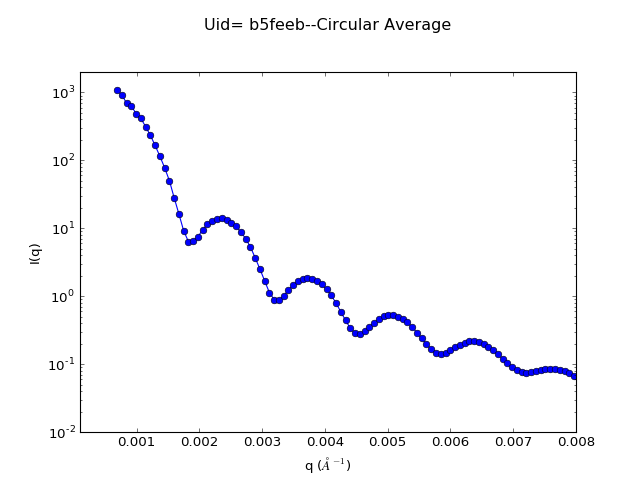

In [18]:
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
                    plot_ = True, show_pixel=False, xlim=[0.0001,.008], ylim = [0.01, 2000])

##  Ring " labels" 

In [19]:
inner_radius= 15
outer_radius = 105
width = 2
num_rings = 14

In [20]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(ring_mask) 

### Ring "lables" marked on the Silica colloidals sample

<IPython.core.display.Javascript object>


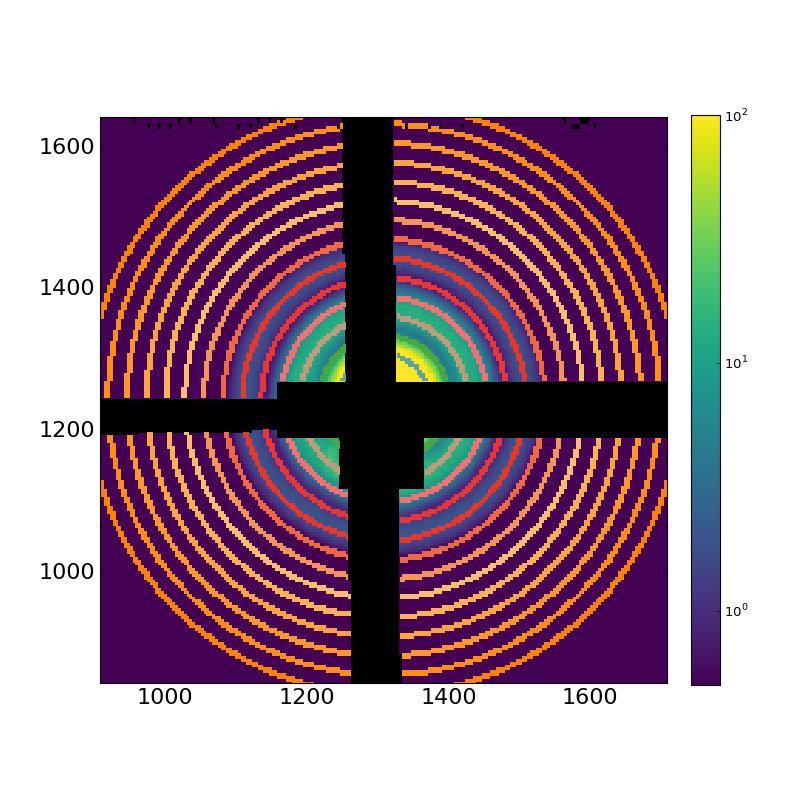

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [21]:
axis_font = {'fontname':'Arial', 'size':'20'}
axis_font2 = {'fontname':'Arial', 'size':'14'}
names = ["ring 1", "ring 2", "ring 3", "ring 4", "ring 5", "ring 6"]
fig, axes = plt.subplots(figsize=(10,10))
im, im_label = roi_plot.show_label_array_on_image(axes, avg_img, ring_mask, cmap="Paired",
                              imshow_cmap=cm, vmin=0.01, vmax=100 , origin="lower",
                              norm=LogNorm(vmin=0.01,  vmax=10))
rwidth = 100
x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim([x1,x2])
axes.set_ylim([y1,y2])
axes.set_yticklabels([800, 1000, 1200, 1400, 1600, 1800], **axis_font)
axes.set_xticklabels([800, 1000, 1200, 1400, 1600, 1800], **axis_font)
fig.colorbar(im, fraction=0.046, pad=0.04) #, vmin=0, vmax=6 )
fig.savefig("labels_silica.svg", bbox_inches='tight')
plt.show()

### Scattered I(q) from the Silica colloidal suspension calculated
### by performing a radial average over the time- averaged 2D scattering pattern (inset).
### The dashed vetical lines show the 11 values of the momentum transfer
### (“q-rings”) which were used in the XPCS analysis.

<IPython.core.display.Javascript object>


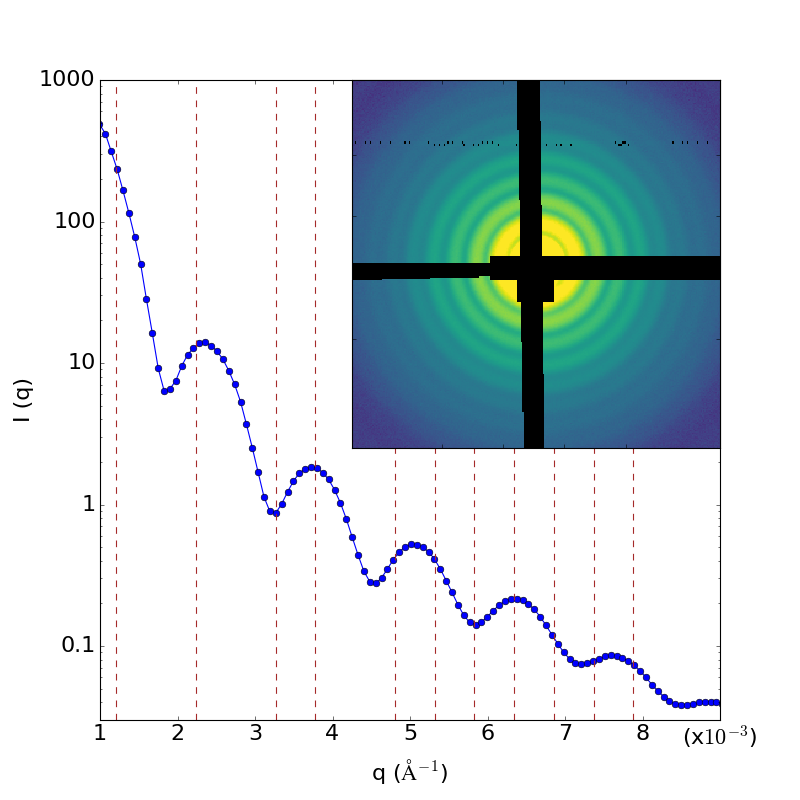

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


  adjustable: [ 'box' | 'datalim' | 'box-forced'] 
  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  anchor: unknown
  animated: [True | False] 
  aspect: unknown
  autoscale_on: unknown
  autoscalex_on: unknown
  autoscaley_on: unknown
  axes: an :class:`~matplotlib.axes.Axes` instance 
  axes_locator: unknown
  axis_bgcolor: any matplotlib color - see :func:`~matplotlib.pyplot.colors` 
  axisbelow: [ *True* | *False* ] 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  color_cycle: unknown
  contains: a callable function 
  figure: unknown
  frame_on: [ *True* | *False* ] 
  gid: an id string 
  label: string or anything printable with '%s' conversion. 
  navigate: [ *True* | *False* ] 
  navigate_mode: unknown
  path_effects: unknown
  picker: [None|float|boolean|callable] 
  positi

In [85]:
bad_q = [ 1, 3, 6]
import matplotlib as mpl
ticklabelpad = mpl.rcParams['xtick.major.pad']
fig, axes = plt.subplots(figsize=(10, 10))
axes.semilogy(q, iq, '-o')
axes.set_ylabel('I (q)', **axis_font)
axes.set_xlabel('q ('r'$\rm \AA^{-1}$)', **axis_font)
axes.set_xlim(0.001, 0.009)
axes.set_ylim(0.03, 1000)
for i in range(num_rings):
    if i not in bad_q:
        axes.axvline(q_ring_center[i] , linestyle="--", color="brown")
axes.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8,  '(x$10^{-3}$)'], **axis_font)
axes.set_yticklabels([10**(-3), 10**(-2), 10**(-1), 10**(0), 10**(1), 10**(2), 10**(3)], **axis_font)
ax = plt.axes([.44, .43, .46, .48], axisbg='y')
im = ax.imshow(avg_img, origin='lower' ,cmap=cm, interpolation="nearest" ,
               norm=LogNorm(vmin=0.001,  vmax=10, clip=False)) 
rwidth = 150
x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
ax.set_xlim( [x1,x2])
ax.set_ylim( [y1,y2])
ax.set_xticks([1150, 1200, 1250, 1300])
ax.set_xticklabels([])
ax.set_yticks([1200, 1250, 1300, 1350])
ax.set_yticklabels([])
fig.savefig("cir_avg.svg", bbox_inches='tight')
fig.savefig("cir_avg.eps", bbox_inches='tight')
plt.setp(ax)
plt.show()

## Get the mean intensities for each ring

Get ROI intensity of each frame: 100%|██████████| 10000/10000 [00:02<00:00, 3753.19it/s]


<IPython.core.display.Javascript object>


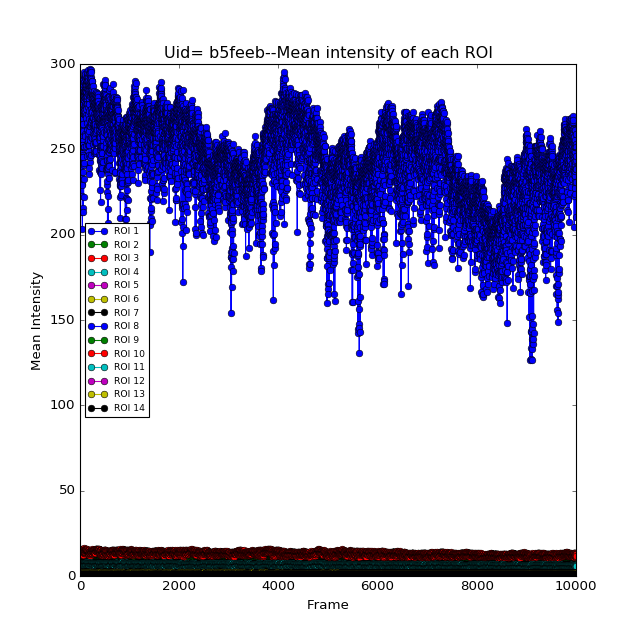

In [23]:
good_series = apply_mask( imgsa[good_start:], mask )
FD = Multifile(filename, 0, len(imgs))
ime_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width=50, edges = None)
times, mean_int_sets = get_each_ring_mean_intensityc(FD, ring_mask,
                                    timeperframe = None, plot_ = True, uid = uid)

## multi-tau one-time corrletaion

In [24]:
num_lev = 8  # number of levels
num_buf = 12  # number of buffers
norm = get_pixelist_interp_iq( qp, iq, ring_mask, center)
t0 = time.time()
g2, lag_steps = cal_g2c(FD, ring_mask, bad_frame_list, good_start, num_buf = 8, 
                        imgsum= None, norm=norm)

In this g2 calculation, the buf and lev number are: 8--12--
Bad frame involved and will be precessed!
10000 frames will be processed...


100%|██████████| 10000/10000 [00:31<00:00, 316.12it/s]

G2 calculation DONE!


In [25]:
taus = lag_steps * timeperframe

##  Plot $g^{(2)}(t)$ s and $g^{(1)}(t)$ 

<IPython.core.display.Javascript object>


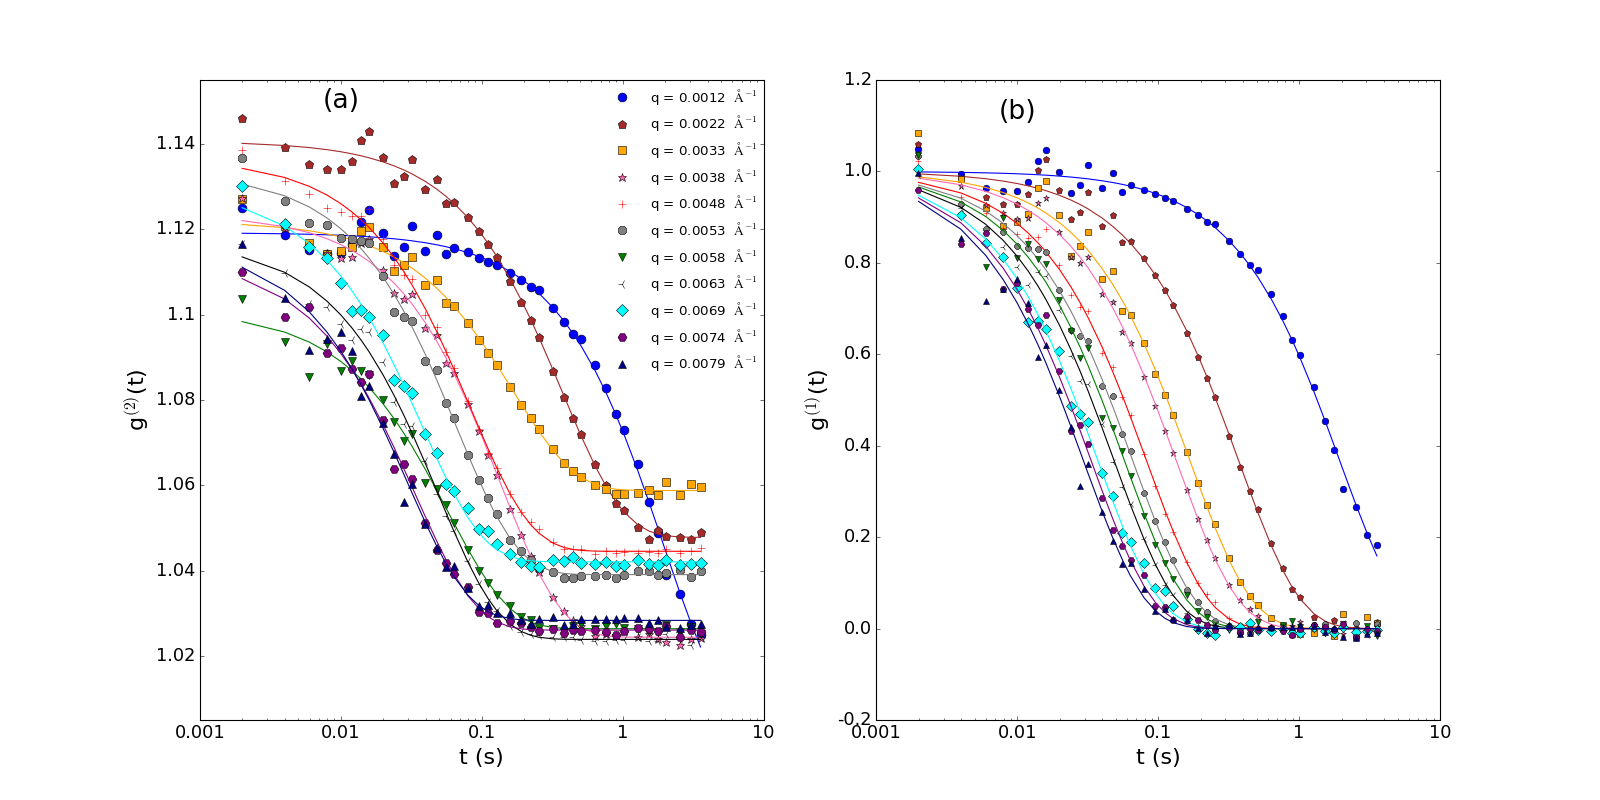

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [120]:
mod = Model(corr.auto_corr_scat_factor)

axis_font = {'fontname':'Arial', 'size':'20'}
axis_font2 = {'fontname':'Arial', 'size':'16'}

beta = []
base = []
rate = []
fig, axes = plt.subplots( 1,2, figsize=(20, 10))

roi_names = ["blue", "darkolivegreen", "brown", "m", "orange", "hotpink", "darkcyan",  "red",
            "gray", "green", "black", "cyan", "purple" , "navy"]
marks = ["o", "2", "p", "1", "s", "*", "4",  "+", "8", "v","3", "D",  "H", "^",]

bad_q = [ 1, 3, 6 ]

for i, roi_color, mark in zip(range(num_rings), roi_names, marks):
    if i not in bad_q:
        y = g2[1:, i]
        result = mod.fit(y, lags=lag_steps[1:], beta=.1,
                         relaxation_rate =.01, baseline=1.0)
        rate.append(result.best_values['relaxation_rate'])
        beta.append(result.best_values['beta'] )
        base.append( result.best_values['baseline'] ) 
        axes[0].semilogx(taus[1:], g2[1:, i], mark, markerfacecolor=roi_color, color=roi_color,
                      markersize=8 , label=" q = " + '%.4f  '%(q_ring_center[i]) + r'$\rm \AA^{-1}$')
        axes[0].semilogx(taus[1:], result.best_fit, '-', c=roi_color)
        
        g1 = ( g2[1:, i] - result.best_values['baseline'])/ result.best_values['beta']
        axes[1].semilogx(taus[1:], g1, mark, markerfacecolor=roi_color, color=roi_color,
                      markersize=6, label=" q = " + '%.4f  '%(q_ring_center[i]) + r'$\rm \AA^{-1}$')
        
        axes[1].semilogx(taus[1:], 
            (  result.best_fit - result.best_values['baseline'])/ result.best_values['beta'],'-', c=roi_color)
axes[0].set_yticklabels([1.00, 1.02, 1.04, 1.06, 1.08, 1.10, 1.12, 1.14,
                      1.16, 1.18], **axis_font2)
axes[0].set_xticklabels([0, 10**(-3), 10**(-2), 10**(-1), 10**(0),
                      10**(1)], **axis_font2) 
axes[0].text(0.01, 1.13, '(a)', size=24, ha='center', va='center')
axes[0].set_ylim([0.985, 1.135])
axes[1].text(0.01, 1.13, '(b)', size=24, ha='center', va='center')
axes[1].set_yticklabels([-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], **axis_font2)
axes[1].set_xticklabels([0, 10**(-3), 10**(-2), 10**(-1), 10**(0),
                      10**(1)], **axis_font2) 
axes[0].set_ylabel("g$^{(2)}$(t)", **axis_font)
axes[0].set_xlabel("t (s)", **axis_font)
axes[1].set_ylabel("g$^{(1)}$(t)", **axis_font)
axes[1].set_xlabel("t (s)", **axis_font)
leg = axes[0].legend(loc=1, fontsize=12,  fancybox=True, framealpha=0.5, borderpad=0, numpoints=1)
leg.get_frame().set_alpha(0)
fig.savefig("g2.svg", bbox_inches='tight')
fig.savefig("g2.eps", bbox_inches='tight')
plt.show()

## Two-time corrleation

In [28]:
FD = Multifile(filename, 0, Nimg)
data_pixel = Get_Pixel_Arrayc(FD, pixelist, norm=norm).get_data()

100%|██████████| 10000/10000 [00:08<00:00, 1217.57it/s]


In [29]:
g12b = auto_two_Arrayc(data_pixel, ring_mask, index=None)

100%|██████████| 14/14 [01:04<00:00,  4.83s/it]


In [30]:
taus2 = np.arange(g12b.shape[0])* 0.002

<IPython.core.display.Javascript object>


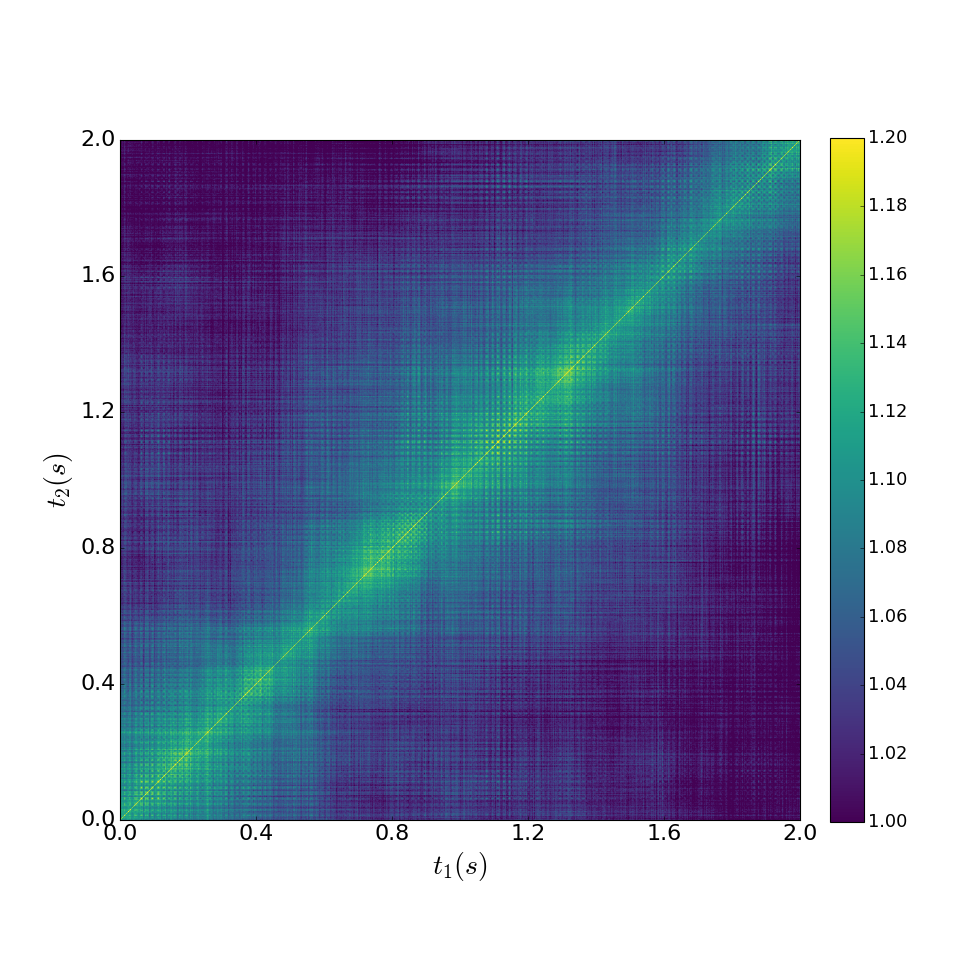

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [107]:
axis_font3 = {'fontname':'Arial', 'size':'25'}

fig, ax1 = plt.subplots(figsize=(12, 12))
im = plt.imshow(g12b[0:1001, 0:1001, 2], vmin=1, vmax=1.2, origin="low", cmap="viridis")
ax1.set_xticks([0, 200, 400, 600, 800, 1000])
ax1.set_yticks([0, 200, 400, 600, 800, 1000])
ax1.set_xticklabels([taus2[0] , taus2[200],  taus2[400],
                   taus2[600],  taus2[800],  taus2[1000]], **axis_font)
ax1.set_yticklabels([taus2[0],  taus2[200],  taus2[400],
                    taus2[600], taus2[800],  taus2[1000]], **axis_font)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16) 
ax1.set_xlabel("$t_{1} (s)}$", **axis_font3)
ax1.set_ylabel("$t_{2} (s)$", **axis_font3)
fig.savefig("C_t1_t2.eps", bbox_inches='tight')
fig.savefig("C_t1_t2.svg", bbox_inches='tight')
plt.show()

In [32]:
noframes = FD.end - FD.beg
num_levels = int(np.log(noframes/(num_buf-1))/np.log(2) +1) +1
tot_channels, lag_steps1, dict_lag = utils.multi_tau_lags(num_levels, num_buf)
max_taus= lag_steps1.max()
max_taus= lag_steps1.max()
g2b = get_one_time_from_two_time(g12b)[:max_taus]
taus21 = np.arange(g2b.shape[0])[:max_taus]*timeperframe

/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  war

# Brute force $g^{(2)}(t)$ extratced from two-time corrletaion data

<IPython.core.display.Javascript object>


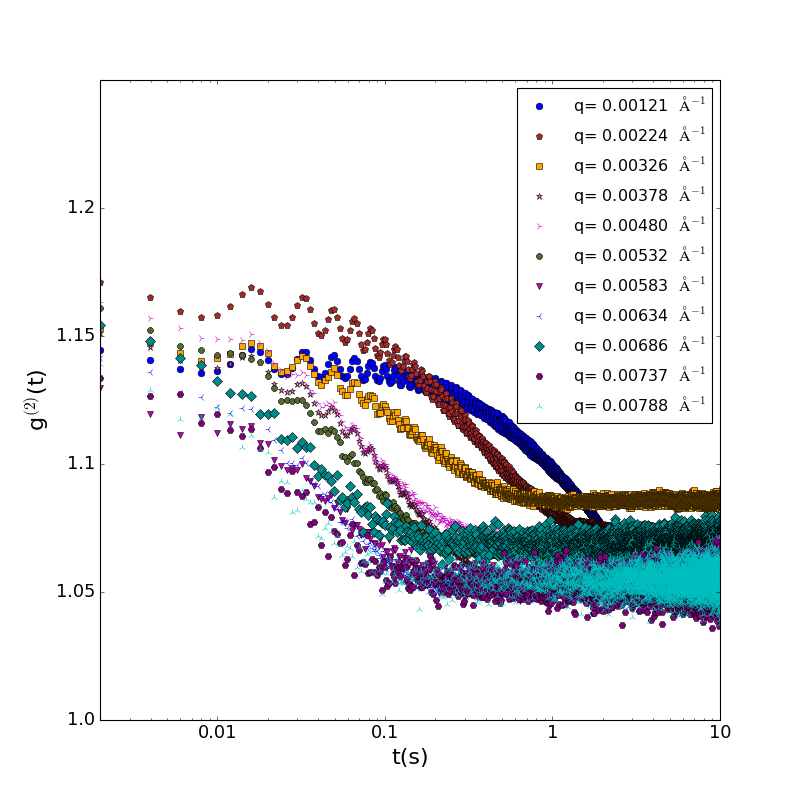

In [65]:
fig, axes = plt.subplots(1, figsize=(10, 10))
for i, roi_color, mark in zip(range(num_rings), roi_names, marks):
    if i not in bad_q:
        y = g2b[1:, i]
        axes.semilogx(taus21[1:], g2b[1:, i], mark, markerfacecolor=roi_color, markersize=6,
                 label=" q= " + '%.5f  '%(q_ring_center[i]) + r'$\rm \AA^{-1}$')
axes.set_ylim(bottom=1, top=1.20)
axes.set_ylabel("g$^{(2)}$(t)", **axis_font)
axes.set_xlabel("t(s)", **axis_font)
axes.set_xlim(0, 10)
axes.set_ylim(0.95, 1.20)
axes.set_yticklabels([0.95, 1.00, 1.05, 1.10, 1.15, 1.20], **axis_font2)
axes.set_xticklabels([0, 10**(-3), 10**(-2), 10**(-1), 10**(0),
                      10**(1)], **axis_font2) 
axes.legend(loc=1, numpoints=1)
plt.show()

## Compared multi-tau one-time corrleation functions and one-time correlation results
## extracted by averaging two time correlation functions over time.

<IPython.core.display.Javascript object>


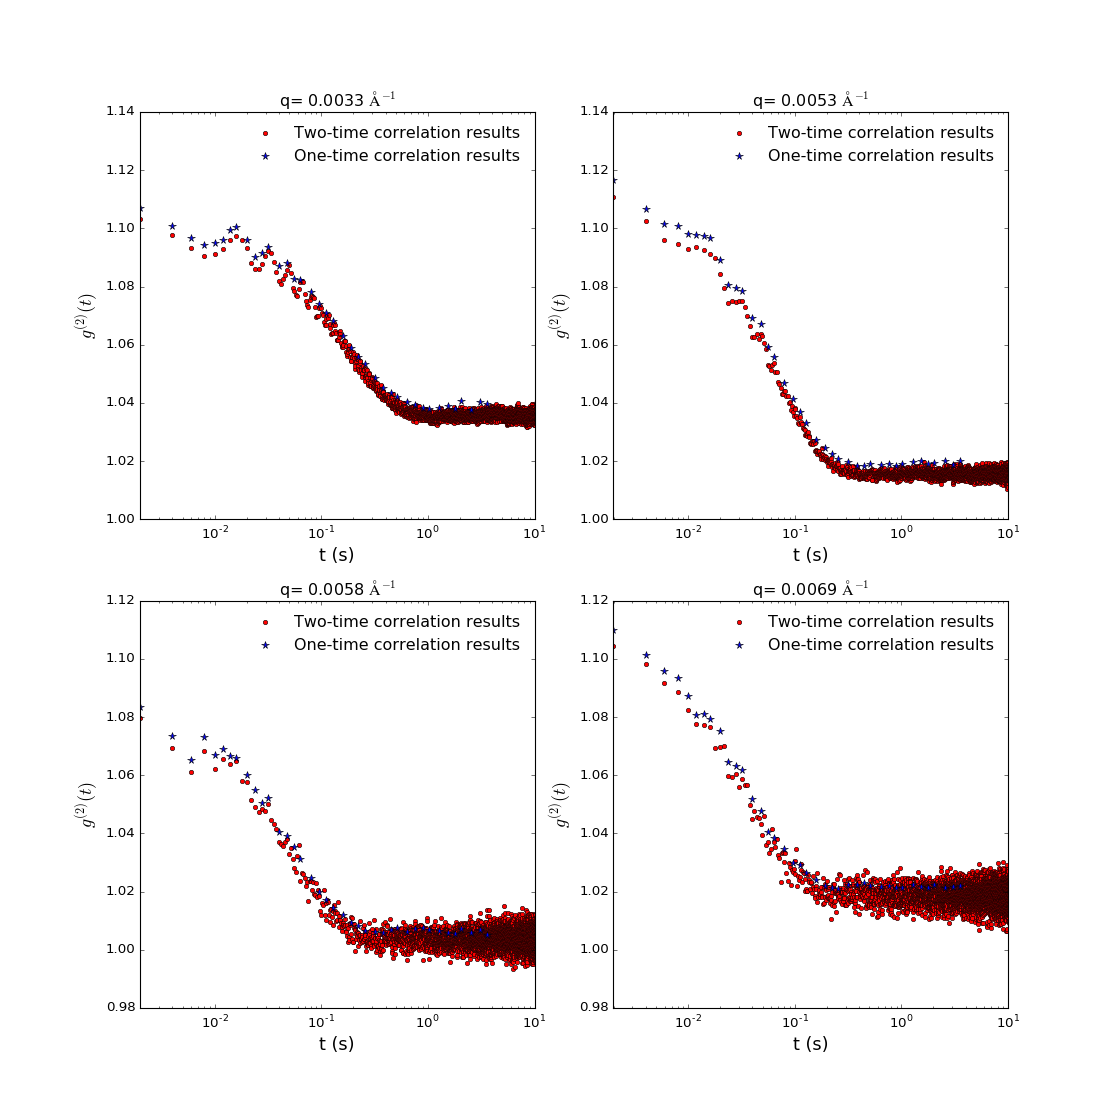

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [99]:
fig, ax = plt.subplots(2, 2,figsize=(14, 14))
#axes[0].subplots(2, 2, 1)
ax[0, 0].set_title
ax[0, 0].set_title("q= %.4f " %q_ring_center[4]+ r'$\rm \AA^{-1}$')
ax[0, 0].set_xlabel("t (s)", **axis_font2)
ax[0, 0].set_ylabel("$g^{(2)}(t)$", **axis_font2)
ax[0, 0].semilogx(taus21[1:], g2b[1:, 4] , 'ro', markersize=4, label="Two-time correlation results")
ax[0, 0].semilogx(taus[1:], g2[1:, 4] , 'b*', markersize=7, label="One-time correlation results")
ax[0, 0].set_xlim(0,10)
ax[0, 0].set_ylim(1.00, 1.14)
leg = ax[0, 0].legend(loc=1, numpoints=1)
leg.get_frame().set_alpha(0)

ax[0, 1].set_title
ax[0, 1].set_title("q= %.4f " %q_ring_center[8]+ r'$\rm \AA^{-1}$')
ax[0, 1].set_xlabel("t (s)", **axis_font2)
ax[0, 1].set_ylabel("$g^{(2)}(t)$", **axis_font2)
ax[0, 1].semilogx(taus21[1:], g2b[1:, 8] , 'ro', markersize=4, label="Two-time correlation results")
ax[0, 1].semilogx(taus[1:], g2[1:, 8] , 'b*', markersize=7, label="One-time correlation results")
ax[0, 1].set_xlim(0,10)
ax[0, 1].set_ylim(1.00, 1.14)
leg = ax[0, 1].legend(loc=1, numpoints=1)
leg.get_frame().set_alpha(0)

ax[1, 0].set_title
ax[1, 0].set_title("q= %.4f " %q_ring_center[9]+ r'$\rm \AA^{-1}$')
ax[1, 0].set_xlabel("t (s)", **axis_font2)
ax[1, 0].set_ylabel("$g^{(2)}(t)$", **axis_font2)
ax[1, 0].semilogx(taus21[1:], g2b[1:, 9] , 'ro', markersize=4, label="Two-time correlation results")
ax[1, 0].semilogx(taus[1:], g2[1:, 9] , 'b*', markersize=7, label="One-time correlation results")
ax[1, 0].set_xlim(0,10)
ax[1, 0].set_ylim(0.98, 1.12)
leg = ax[1, 0].legend(loc=1, numpoints=1)
leg.get_frame().set_alpha(0)

ax[1, 1].set_title
ax[1, 1].set_title("q= %.4f " %q_ring_center[11]+ r'$\rm \AA^{-1}$')
ax[1, 1].set_xlabel("t (s)", **axis_font2)
ax[1, 1].set_ylabel("$g^{(2)}(t)$", **axis_font2)
ax[1, 1].semilogx(taus21[1:], g2b[1:, 11] , 'ro', markersize=4, label="Two-time correlation results")
ax[1, 1].semilogx(taus[1:], g2[1:, 11] , 'b*', markersize=7, label="One-time correlation results")
ax[1, 1].set_xlim(0,10)
ax[1, 1].set_ylim(0.98, 1.12)
leg = ax[1, 1].legend(loc=1, numpoints=1)
leg.get_frame().set_alpha(0)
fig.savefig("g2_and_g2b.svg", bbox_inches='tight')
fig.savefig("g2_and_g2b.eps", bbox_inches='tight')
plt.show()

## Find the relaxtaion rates

In [43]:
data_dir = os.getcwd()+"/"

In [91]:
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid)
res_pargs2 = dict(taus=taus21, q_ring_center=q_ring_center, path=data_dir, uid=uid)

<IPython.core.display.Javascript object>


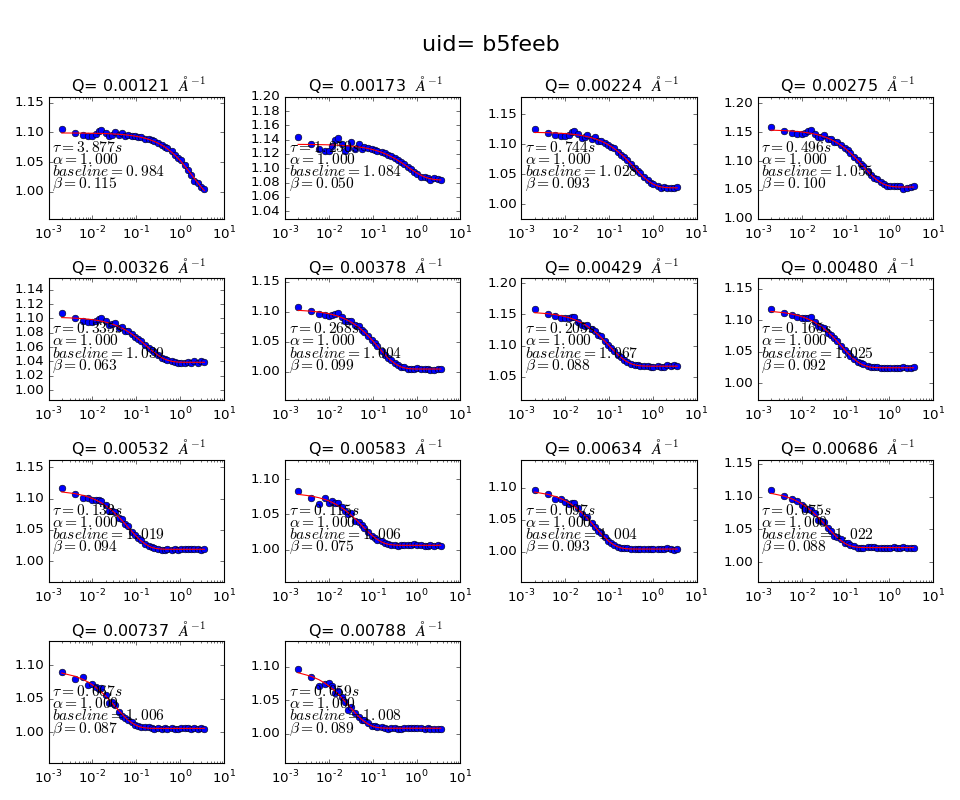

The fitted diffusion coefficient D0 is:  2.49E+03   A^2S-1


<IPython.core.display.Javascript object>


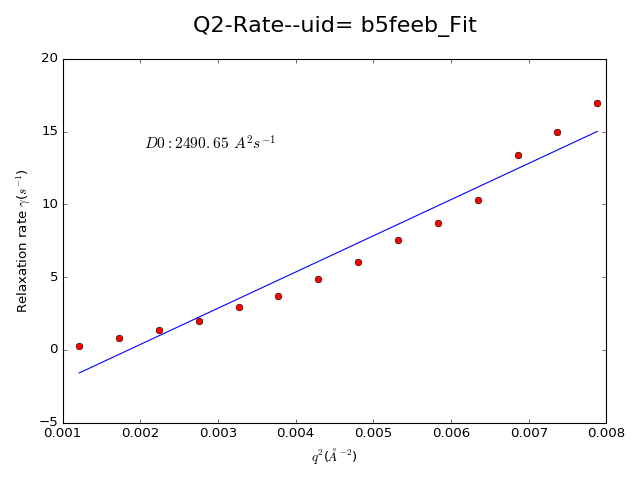

array([ 2490.64516561,    -4.61004326])

In [92]:
from chxanalys.XPCS_SAXS import fit_q2_rate, fit_saxs_g2
result = fit_saxs_g2(g2, res_pargs, function="simple")
fit_q2_rate(q_ring_center, result['rate'], uid=uid, path=data_dir)

In [93]:
result['rate']

array([  0.25794564,   0.79990811,   1.34464572,   2.01619282,
         2.98115569,   3.72487388,   4.88396502,   6.05636861,
         7.58789149,   8.69111669,  10.28709199,  13.41167236,
        14.98216271,  16.99406482])

##  Diffusion coefficent

In [94]:
D0

array([  2.74844460e+05,  -1.43046213e-01])

<IPython.core.display.Javascript object>


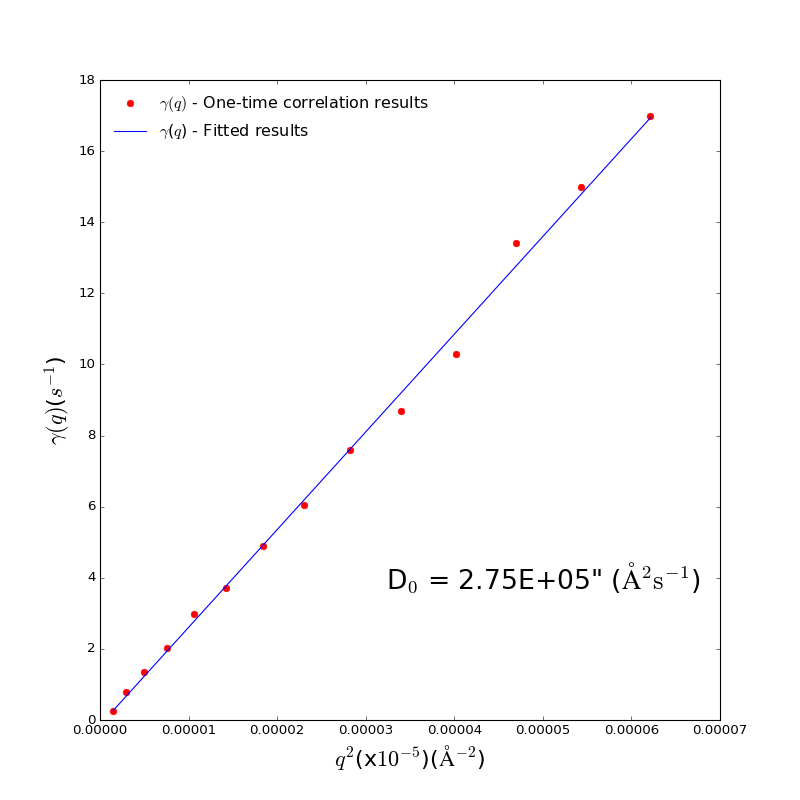

In [97]:
fig , ax1 = plt.subplots(figsize=(10, 10))
ax1.plot(q_ring_center**2, result['rate'], "ro", markerfacecolor=None,
         markeredgecolor='r', label="$\gamma(q)$ - One-time correlation results")
ax1.plot(q_ring_center**2, gmfit(q_ring_center**2), ls="-", label="$\gamma$($q$) - Fitted results")
ax1.text(0.00005,  4 , 'D$_{0}$ = %.2E" ' r'($\rm \AA^{2} s^{-1}$)' %D0[0], size=24, ha='center', va='center')
ax1.set_ylabel(''r'$\gamma(q)$'"($s^{-1}$)", **axis_font)
ax1.set_xlabel("$q^2$(x$10^{-5}$)"r'($\rm \AA^{-2}$)', **axis_font)
leg = plt.legend(loc=2, numpoints=1)
leg.get_frame().set_alpha(0)
plt.show()